<a href="https://colab.research.google.com/github/mbenedicto99/AIClimateProject/blob/main/LSTM_Comparativo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM Multi-step - Emissão de CO2

Baixando dados reais de emissões de CO₂...
Registros para World:
       year        co2
49777  2020  35158.230
49778  2021  36866.863
49779  2022  37527.773
49780  2023  38094.039
49781  2024  38598.578
Formato X: (41, 20, 1)
Formato y: (41, 5)
Treino: (28, 20, 1) (28, 5)
Validação: (6, 20, 1) (6, 5)
Teste: (7, 20, 1) (7, 5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,533 (119.27 KB)

 Trainable params: 30,533 (119.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - loss: 0.2780 - mae: 0.5091 - val_loss: 0.6278 - val_mae: 0.7903 - learning_rate: 0.0010
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2108 - mae: 0.4415 - val_loss: 0.4762 - val_mae: 0.6785 - learning_rate: 0.0010
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1599 - mae: 0.3654 - val_loss: 0.2799 - val_mae: 0.4620 - learning_rate: 0.0010
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0940 - mae: 0.2292 - val_loss: 0.1495 - val_mae: 0.2913 - learning_rate: 0.0010
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0551 - mae: 0.1991 - val_loss: 0.0764 - val_mae: 0.2284 - learning_rate: 0.0010
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0197 - mae: 0.1125 - val_loss: 0.0829 - val_mae: 0.2638 - learning_rate: 0.0010
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0177 - mae: 0.1024 - val_loss: 0.0497 - val_mae: 0.1996 - learning_rate: 0.0010
Epoch 8/300
4/4 ━━━

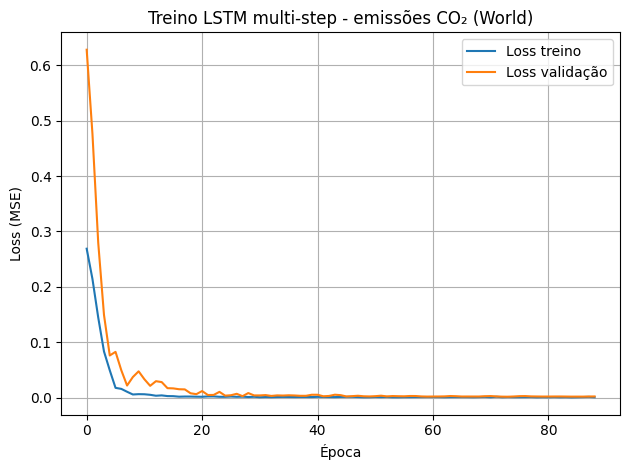

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


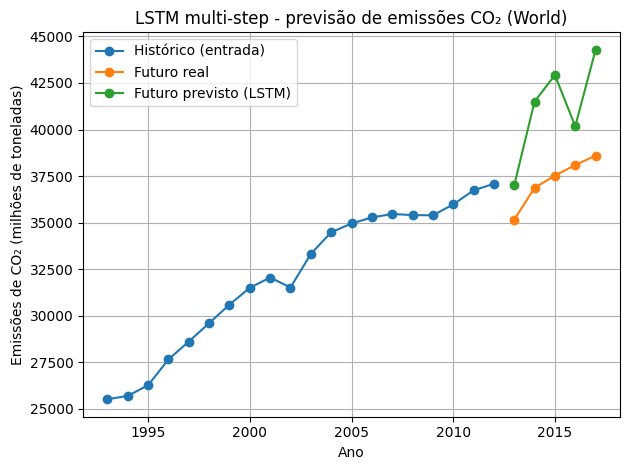

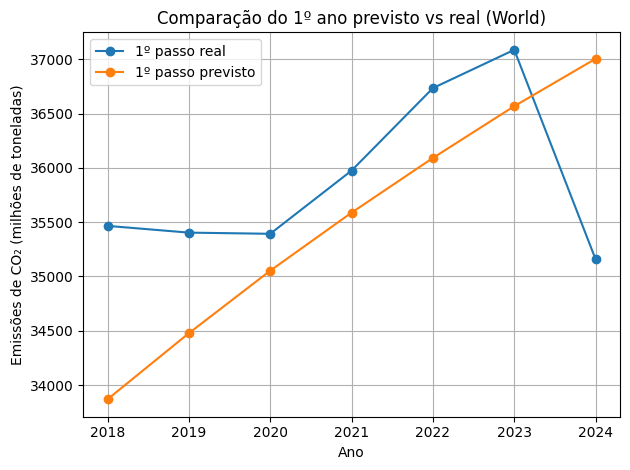

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ============================
# 1) Configurações principais
# ============================

# País ou "World" (como está no dataset do Our World in Data)
COUNTRY = "World"     # mude para "Brazil", "China", etc. se quiser

# Tamanho da janela de histórico (em anos)
WINDOW_SIZE = 20

# Horizonte de previsão (quantos anos à frente)
HORIZON = 5

# ============================
# 2) Carregar dados reais CO2
# ============================

# Dataset Our World in Data (emissões de CO₂ e GEE)
# Fonte: https://github.com/owid/co2-data
URL = "https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv"

print("Baixando dados reais de emissões de CO₂...")
df = pd.read_csv(URL)

# Filtrar país/mundo escolhido
df_country = df[df["country"] == COUNTRY].copy()

# Usar apenas colunas de interesse: ano + emissões de CO₂ (em milhões de toneladas)
df_country = df_country[["year", "co2"]].dropna()

# Opcional: focar em anos mais recentes
df_country = df_country[df_country["year"] >= 1960]

df_country = df_country.sort_values("year")

print(f"Registros para {COUNTRY}:")
print(df_country.tail())

years = df_country["year"].values
co2_values = df_country["co2"].values.reshape(-1, 1)  # formato (n, 1)

# ============================
# 3) Normalizar a série
# ============================

scaler = MinMaxScaler()
co2_scaled = scaler.fit_transform(co2_values)

# ============================
# 4) Criar janelas multi-step
# ============================

def create_multistep_windows(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        x_window = data[i : i + window_size]                       # (window_size, 1)
        y_window = data[i + window_size : i + window_size + horizon]  # (horizon, 1)
        X.append(x_window)
        y.append(y_window.flatten())  # (horizon,)
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = create_multistep_windows(co2_scaled, WINDOW_SIZE, HORIZON)

print("Formato X:", X.shape)  # (N, window_size, 1)
print("Formato y:", y.shape)  # (N, horizon)

# ============================
# 5) Split treino / val / teste
# ============================

n_samples = len(X)
train_end = int(0.7 * n_samples)
val_end = int(0.85 * n_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print("Treino:", X_train.shape, y_train.shape)
print("Validação:", X_val.shape, y_val.shape)
print("Teste:", X_test.shape, y_test.shape)

# ============================
# 6) Modelo LSTM multi-step
# ============================

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation="relu"),
    Dense(HORIZON)  # previsão de HORIZON anos à frente
])

model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)

model.summary()

# ============================
# 7) Callbacks
# ============================

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=7,
    verbose=1
)

# ============================
# 8) Treinamento
# ============================

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=8,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ============================
# 9) Gráfico do Loss
# ============================

plt.figure()
plt.plot(history.history["loss"], label="Loss treino")
plt.plot(history.history["val_loss"], label="Loss validação")
plt.xlabel("Época")
plt.ylabel("Loss (MSE)")
plt.title(f"Treino LSTM multi-step - emissões CO₂ ({COUNTRY})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================
# 10) Previsões no teste
# ============================

y_pred = model.predict(X_test)  # (N_test, HORIZON)

# Desnormalizar
y_test_flat = y_test.reshape(-1, 1)
y_pred_flat = y_pred.reshape(-1, 1)

y_test_inv_flat = scaler.inverse_transform(y_test_flat)
y_pred_inv_flat = scaler.inverse_transform(y_pred_flat)

y_test_inv = y_test_inv_flat.reshape(y_test.shape)
y_pred_inv = y_pred_inv_flat.reshape(y_pred.shape)

# ============================
# 11) Visualizar um exemplo
# ============================

idx = -1  # última janela de teste (mais recente)

input_window = X_test[idx].reshape(WINDOW_SIZE, 1)
input_window_inv = scaler.inverse_transform(input_window).flatten()

true_future = y_test_inv[idx]
pred_future = y_pred_inv[idx]

# Montar anos relativos
start_year_input = years[len(years) - len(y_test_inv) - WINDOW_SIZE - HORIZON + 1 + idx]
# anos do histórico
years_input = np.arange(start_year_input, start_year_input + WINDOW_SIZE)
# anos do futuro
years_future = np.arange(start_year_input + WINDOW_SIZE,
                         start_year_input + WINDOW_SIZE + HORIZON)

plt.figure()
plt.plot(years_input, input_window_inv, marker="o", label="Histórico (entrada)")
plt.plot(years_future, true_future, marker="o", label="Futuro real")
plt.plot(years_future, pred_future, marker="o", label="Futuro previsto (LSTM)")
plt.xlabel("Ano")
plt.ylabel("Emissões de CO₂ (milhões de toneladas)")
plt.title(f"LSTM multi-step - previsão de emissões CO₂ ({COUNTRY})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================
# 12) Visualizar primeiro passo
# ============================

first_step_true = y_test_inv[:, 0]
first_step_pred = y_pred_inv[:, 0]

# anos correspondentes ao 1º passo à frente de cada janela de teste
start_year_first_step = years[len(years) - len(first_step_true)]
years_first_step = np.arange(start_year_first_step,
                             start_year_first_step + len(first_step_true))

plt.figure()
plt.plot(years_first_step, first_step_true, marker="o", label="1º passo real")
plt.plot(years_first_step, first_step_pred, marker="o", label="1º passo previsto")
plt.xlabel("Ano")
plt.ylabel("Emissões de CO₂ (milhões de toneladas)")
plt.title(f"Comparação do 1º ano previsto vs real ({COUNTRY})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LSTM Multivariada - Emissão de CO2, PIB, População e Consumo de Energia

Baixando dados de CO₂ (Our World in Data)...
Últimas linhas de World:
       year        co2           gdp    population  primary_energy_consumption
49777  2020  35158.230  1.185900e+14  7.887001e+09                  157993.891
49778  2021  36866.863  1.260048e+14  7.954448e+09                  166043.500
49779  2022  37527.773  1.301126e+14  8.021407e+09                  169061.531
49780  2023  38094.039  1.301126e+14  8.091735e+09                  172238.781
49781  2024  38598.578  1.301126e+14  8.161973e+09                  176737.094
Formato X: (41, 20, 4)
Formato y: (41, 5)
Treino: (28, 20, 4) (28, 5)
Validação: (6, 20, 4) (6, 5)
Teste: (7, 20, 4) (7, 5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 20, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,301 (122.27 KB)

 Trainable params: 31,301 (122.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - loss: 0.1903 - mae: 0.4176 - val_loss: 0.2905 - val_mae: 0.5104 - learning_rate: 0.0010
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0839 - mae: 0.2458 - val_loss: 0.1264 - val_mae: 0.2610 - learning_rate: 0.0010
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0397 - mae: 0.1621 - val_loss: 0.0690 - val_mae: 0.2271 - learning_rate: 0.0010
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0328 - mae: 0.1484 - val_loss: 0.0553 - val_mae: 0.2104 - learning_rate: 0.0010
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0143 - mae: 0.0927 - val_loss: 0.0701 - val_mae: 0.2499 - learning_rate: 0.0010
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0132 - mae: 0.0852 - val_loss: 0.0525 - val_mae: 0.2228 - learning_rate: 0.0010
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0069 - mae: 0.0593 - val_loss: 0.0311 - val_mae: 0.1699 - learning_rate: 0.0010
Epoch 8/300
4/4 ━━━

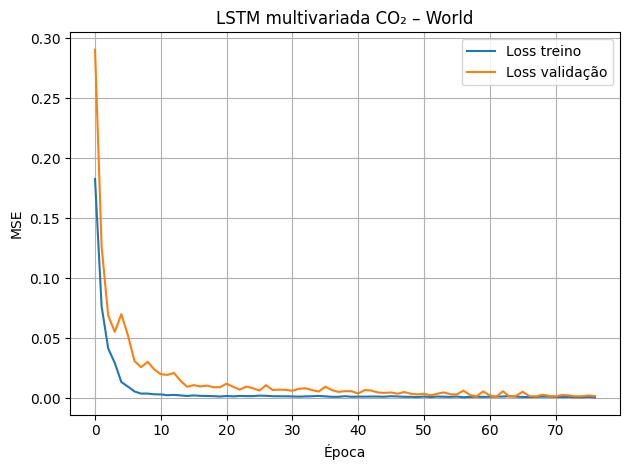

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step

Métricas por horizonte (anos à frente):
1º ano: MAE = 1386.670, RMSE = 1803.314
2º ano: MAE = 2085.208, RMSE = 2351.667
3º ano: MAE = 694.128, RMSE = 1035.670
4º ano: MAE = 2051.733, RMSE = 2290.705
5º ano: MAE = 2881.519, RMSE = 3034.785


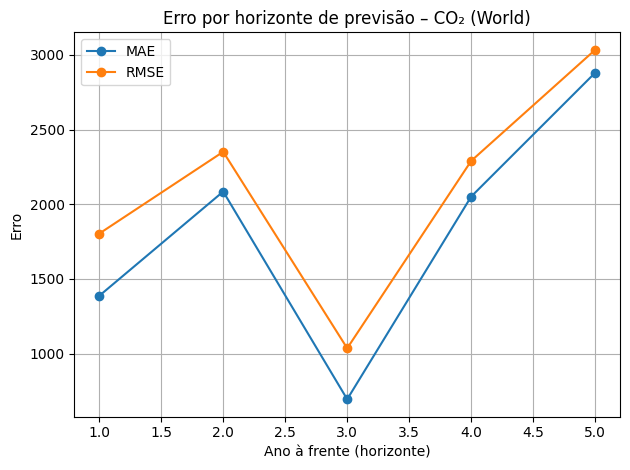

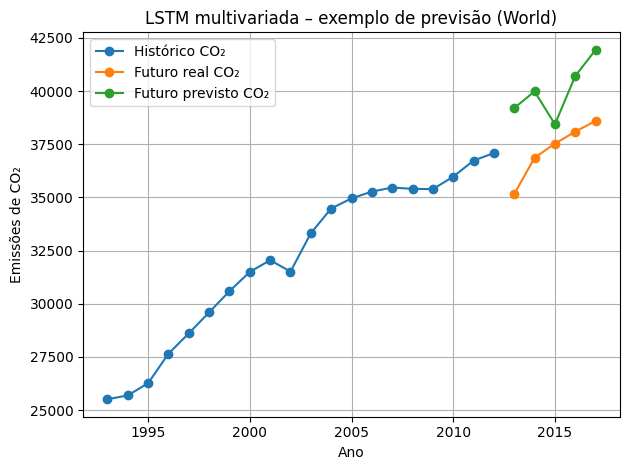

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ============================
# 1) Configurações principais
# ============================

COUNTRY = "World"   # mude para "Brazil", "China", etc.
WINDOW_SIZE = 20    # anos de histórico
HORIZON = 5         # anos à frente

# ============================
# 2) Carregar dados OWID reais
# ============================

URL = "https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv"
print("Baixando dados de CO₂ (Our World in Data)...")
df = pd.read_csv(URL)

df = df[df["country"] == COUNTRY].copy()

# Selecionar features (multivariado)
features = [
    "co2",                          # alvo principal
    "gdp",                          # PIB
    "population",                   # população
    "primary_energy_consumption"    # consumo de energia primária
]

df = df[["year"] + features].sort_values("year")
df = df[df["year"] >= 1960]   # opcional: limitar período

# Preencher faltantes (ffill/bfill)
df[features] = df[features].ffill().bfill()

print(f"Últimas linhas de {COUNTRY}:")
print(df.tail())

years = df["year"].values
data_values = df[features].values   # shape (n_anos, n_features)

n_features = data_values.shape[1]

# ============================
# 3) Normalização
# ============================

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_values)

# ============================
# 4) Criar janelas multi-step
#    X: (janela, n_features)
#    y: CO2 futuros (horizon,)
# ============================

def create_multistep_windows_multivariate(data, window_size, horizon, target_index=0):
    """
    data: array (N, n_features) normalizado
    target_index: índice da coluna que será o alvo (co2 = 0)
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        x_window = data[i : i + window_size, :]  # (window_size, n_features)
        y_window = data[i + window_size : i + window_size + horizon, target_index]  # (horizon,)
        X.append(x_window)
        y.append(y_window)
    return np.array(X), np.array(y)

X, y = create_multistep_windows_multivariate(data_scaled, WINDOW_SIZE, HORIZON, target_index=0)

print("Formato X:", X.shape)  # (N, window_size, n_features)
print("Formato y:", y.shape)  # (N, horizon)

# ============================
# 5) Split temporal
# ============================

n_samples = len(X)
train_end = int(0.7 * n_samples)
val_end = int(0.85 * n_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print("Treino:", X_train.shape, y_train.shape)
print("Validação:", X_val.shape, y_val.shape)
print("Teste:", X_test.shape, y_test.shape)

# ============================
# 6) Modelo LSTM multivariado
# ============================

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation="relu"),
    Dense(HORIZON)   # multi-step direto
])

model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)

model.summary()

# ============================
# 7) Callbacks
# ============================

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=7,
    verbose=1
)

# ============================
# 8) Treinamento
# ============================

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=8,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ============================
# 9) Curva de loss
# ============================

plt.figure()
plt.plot(history.history["loss"], label="Loss treino")
plt.plot(history.history["val_loss"], label="Loss validação")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title(f"LSTM multivariada CO₂ – {COUNTRY}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================
# 10) Avaliação no teste
# ============================

y_pred = model.predict(X_test)   # (N_test, HORIZON)

# Precisamos desnormalizar apenas a coluna CO2 (índice 0)
# Para isso, montamos arrays artificiais com n_features, alterando só a coluna 0.

def inverse_transform_target(scaled_target_column, scaler, target_index, n_features):
    """
    scaled_target_column: (N, ) ou (N, HORIZON) em escala [0,1]
    Retorna em escala original só o alvo.
    """
    shape = scaled_target_column.shape
    flat = scaled_target_column.reshape(-1, 1)  # (N*H, 1) se H>1
    # Montar matriz com n_features colunas para usar o scaler inverso
    tmp = np.zeros((flat.shape[0], n_features))
    tmp[:, target_index] = flat[:, 0]
    inv = scaler.inverse_transform(tmp)
    return inv[:, target_index].reshape(shape)

# Desnormalizar CO₂ real e previsto
y_test_inv  = inverse_transform_target(y_test,  scaler, target_index=0, n_features=n_features)
y_pred_inv  = inverse_transform_target(y_pred,  scaler, target_index=0, n_features=n_features)

# ============================
# 11) Métricas por horizonte
# ============================

horizon_mae = []
horizon_rmse = [] # Corrected typo from hotizon_rmse to horizon_rmse

for h in range(HORIZON):
    mae_h = mean_absolute_error(y_test_inv[:, h], y_pred_inv[:, h])
    rmse_h = np.sqrt(mean_squared_error(y_test_inv[:, h], y_pred_inv[:, h]))
    horizon_mae.append(mae_h)
    horizon_rmse.append(rmse_h)

print("\nMétricas por horizonte (anos à frente):")
for h in range(HORIZON):
    print(f"{h+1}º ano: MAE = {horizon_mae[h]:.3f}, RMSE = {horizon_rmse[h]:.3f}")

# Gráfico das métricas por horizonte
plt.figure()
plt.plot(range(1, HORIZON+1), horizon_mae, marker="o", label="MAE")
plt.plot(range(1, HORIZON+1), horizon_rmse, marker="o", label="RMSE")
plt.xlabel("Ano à frente (horizonte)")
plt.ylabel("Erro")
plt.title(f"Erro por horizonte de previsão – CO₂ ({COUNTRY})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================
# 12) Visualizar uma janela
# ============================

idx = -1  # última janela de teste (mais recente)

input_window_scaled = X_test[idx]   # (WINDOW_SIZE, n_features)
input_co2_scaled = input_window_scaled[:, 0].reshape(-1, 1)

# Desnormalizar só CO₂ do histórico
input_co2_inv = inverse_transform_target(
    input_co2_scaled.flatten(), scaler, target_index=0, n_features=n_features
)

true_future = y_test_inv[idx]   # (HORIZON,)
pred_future = y_pred_inv[idx]   # (HORIZON,)

# Construir anos relativos para esse exemplo
start_index_for_example = len(years) - (len(y_test_inv) + HORIZON + WINDOW_SIZE) + idx + 1
years_input = years[start_index_for_example : start_index_for_example + WINDOW_SIZE]
years_future = years[start_index_for_example + WINDOW_SIZE :
                     start_index_for_example + WINDOW_SIZE + HORIZON]

plt.figure()
plt.plot(years_input, input_co2_inv, marker="o", label="Histórico CO₂")
plt.plot(years_future, true_future, marker="o", label="Futuro real CO₂")
plt.plot(years_future, pred_future, marker="o", label="Futuro previsto CO₂")
plt.xlabel("Ano")
plt.ylabel("Emissões de CO₂")
plt.title(f"LSTM multivariada – exemplo de previsão ({COUNTRY})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()